This project uses [`GWFSS_v1.0_labelled`](https://huggingface.co/datasets/GlobalWheat/GWFSS_v1.0) from the [Global Wheat Full Semantic Organ Segmentation](https://doi.org/10.1016/j.plaphe.2025.100084) dataset.

### Import Libraries

In [ ]:
from datasets import load_dataset, load_from_disk
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import json
from pathlib import Path

### Import Data

In [ ]:
# Define path
dataset_path = Path("./data")

# Check if dataset is saved to disk
if dataset_path.exists() and (dataset_path / "dataset_dict.json").exists():
    print("Loading dataset from disk...")
    dataset = load_from_disk(str(dataset_path))
    print(f"✓ Loaded {len(dataset['labelled'])} examples from disk")
    
# If not on disk, check if dataset variable exists in memory
elif 'dataset' in globals() and dataset is not None:
    print("Dataset variable found in memory, saving to disk...")
    dataset.save_to_disk(str(dataset_path))
    print(f"✓ Saved {len(dataset['labelled'])} examples to disk")
    
# Otherwise, load from HuggingFace and save
else:
    print("Loading dataset from HuggingFace...")
    dataset = load_dataset("GlobalWheat/GWFSS_v1.0")
    print(f"✓ Loaded {len(dataset['labelled'])} examples from HuggingFace")
    
    print("Saving dataset to disk...")
    dataset.save_to_disk(str(dataset_path))
    print(f"✓ Saved dataset to disk")

Loading dataset from disk...
✓ Loaded 1096 examples from disk


### Preview Images

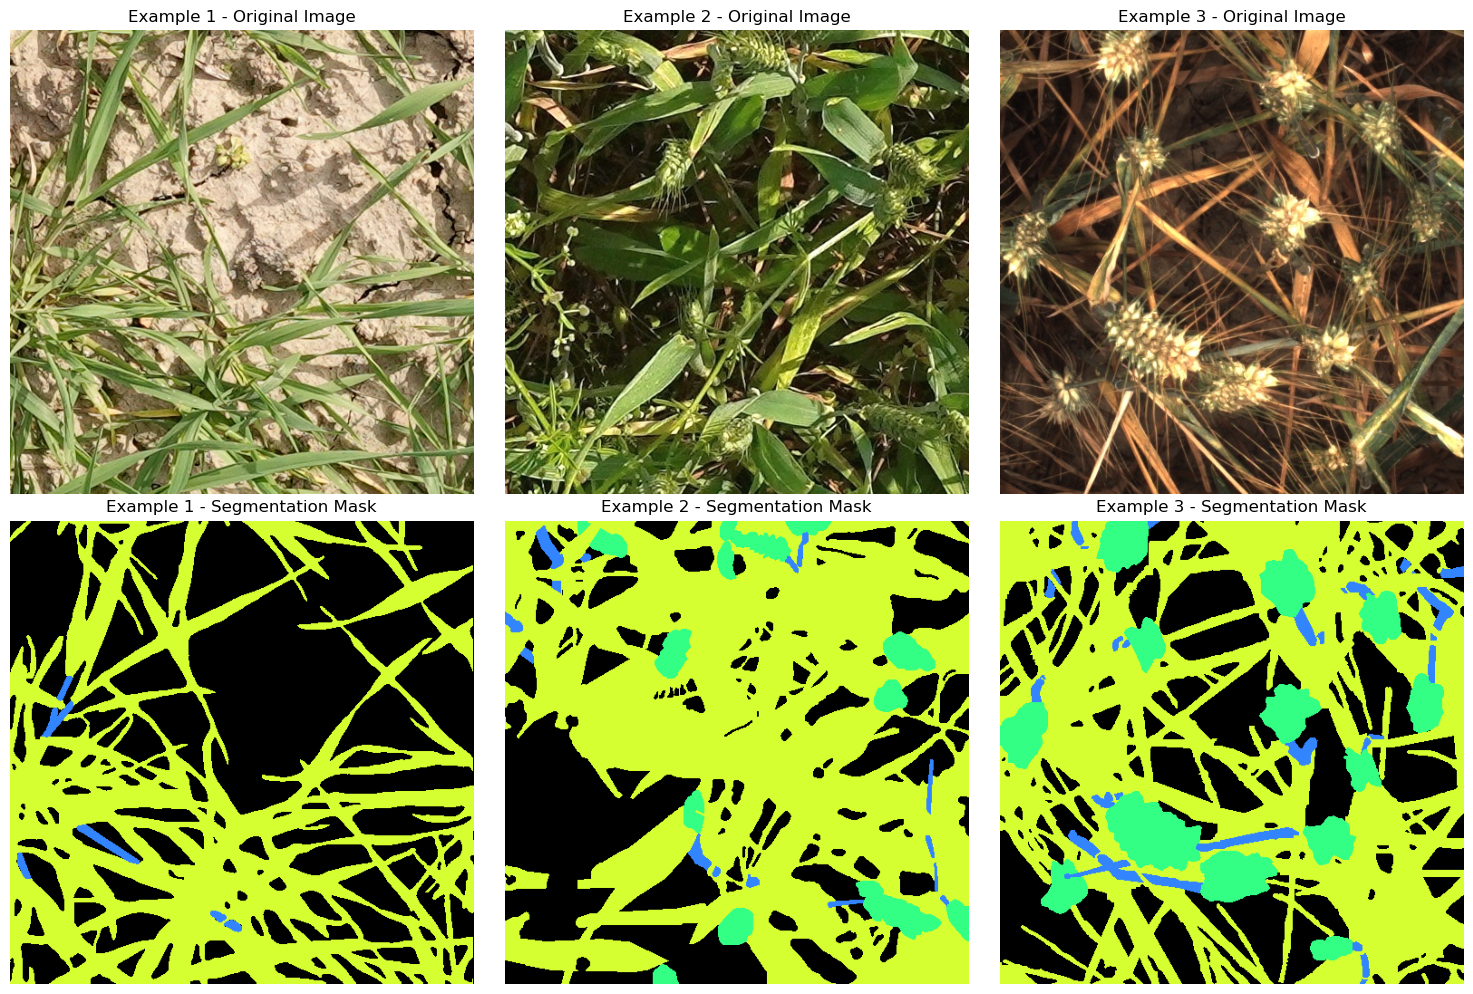

In [3]:
# Get 3 examples
examples = [dataset["labelled"][i] for i in range(3)]

# Preview
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, example in enumerate(examples):
    image = example["image"]
    mask = example["mask"]
    
    # Original image (top row)
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Example {i+1} - Original Image")
    axes[0, i].axis('off')
    
    # Segmentation mask (bottom row)
    axes[1, i].imshow(mask)
    axes[1, i].set_title(f"Example {i+1} - Segmentation Mask")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Map Classes

In [ ]:
# Find unique RGB triplets
sample_size = 10
all_rgb_triplets = set() # Use a set to avoid duplicates

for i in range(min(sample_size, len(dataset["labelled"]))):
    example = dataset["labelled"][i]
    mask = np.array(example['mask'])
    rgb_triplets = mask.reshape(-1, 3) # -1 tells NumPy to infer the number of rows when flattening height and width
    unique_rgb = [tuple(rgb) for rgb in np.unique(rgb_triplets, axis=0)] # Use tuples so that the set can be updated
    all_rgb_triplets.update(unique_rgb)

print(f"Unique RGB triplets found:")
for rgb in sorted(all_rgb_triplets):
    print(f"  RGB{rgb}")

Unique RGB triplets found:
  RGB(np.uint8(0), np.uint8(0), np.uint8(0))
  RGB(np.uint8(50), np.uint8(132), np.uint8(255))
  RGB(np.uint8(50), np.uint8(255), np.uint8(132))
  RGB(np.uint8(214), np.uint8(255), np.uint8(50))


In [5]:
# Map RGB triplets to class IDs
rgb_to_class = {
    (0, 0, 0): 0,              # Background (Black)
    (214, 255, 50): 1,         # Leaf (Yellow-green)
    (50, 132, 255): 2,         # Stem (Blue)
    (50, 255, 132): 3,         # Head (Cyan-green)
}

print(f"✓ Mapped RGB triplets to class IDs")

✓ Mapped RGB triplets to class IDs


In [ ]:
# Define path to save/load the class counts
class_counts_path = Path("./cache/class_counts.json")

# Check if class counts are already saved and valid
class_counts = None
if class_counts_path.exists():
    try:
        print("Loading class counts from disk...")
        with open(class_counts_path, 'r') as f:
            class_counts_dict = json.load(f)
        # Validate the loaded data
        if isinstance(class_counts_dict, dict) and len(class_counts_dict) == 4:
            # Convert back to defaultdict
            class_counts = defaultdict(list, {int(k): v for k, v in class_counts_dict.items()})
            print(f"✓ Loaded class counts from disk")
        else:
            print("⚠ Saved file appears invalid, recomputing...")
            class_counts = None
    except (json.JSONDecodeError, ValueError) as e:
        print(f"⚠ Error loading saved file ({e}), recomputing...")
        class_counts = None

# If loading failed or file doesn't exist, compute it
if class_counts is None:
    print("Computing class counts...")
    # Initialise a dictionary to count pixel occurrences for each class
    class_counts = defaultdict(list)

    # Iterate through all labelled examples in the dataset
    for example in dataset["labelled"]:
        # Convert mask to numpy array (RGB encoded)
        mask = np.array(example['mask'])
        
        # Reshape to get all RGB triplets
        rgb_triplets = mask.reshape(-1, 3)
        
        # Get unique RGB triplets and their counts in this mask
        unique_rgb, counts = np.unique(rgb_triplets, axis=0, return_counts=True)
        
        # Create a dictionary mapping RGB triplet to pixel count for this image
        count_dict = {tuple(rgb): count for rgb, count in zip(unique_rgb, counts)}
        
        # Map RGB triplets to class IDs and append pixel counts
        # Initialise counts for all 4 classes
        image_class_counts = [0, 0, 0, 0]
        
        # Iterate through RGB values found in this image and map to classes
        for rgb_tuple, count in count_dict.items():
            if rgb_tuple in rgb_to_class:
                class_id = rgb_to_class[rgb_tuple]
                image_class_counts[class_id] = count
        
        # Append counts for this image (convert numpy types to native Python int)
        for class_id in range(4):
            class_counts[class_id].append(int(image_class_counts[class_id]))

    # Save to disk (convert numpy types to native Python types)
    print("Saving class counts to disk...")
    # Convert defaultdict to dict and ensure all values are native Python types
    class_counts_dict = {
        str(k): [int(val) for val in v] 
        for k, v in class_counts.items()
    }
    with open(class_counts_path, 'w') as f:
        json.dump(class_counts_dict, f)
    print(f"✓ Counted pixel occurrences for each class and saved to disk")

Loading class counts from disk...
⚠ Error loading saved file (Expecting value: line 1 column 8 (char 7)), recomputing...
Computing class counts (this may take a while)...
Saving class counts to disk...
✓ Counted pixel occurrences for each class and saved to disk


### Check Class Imbalance

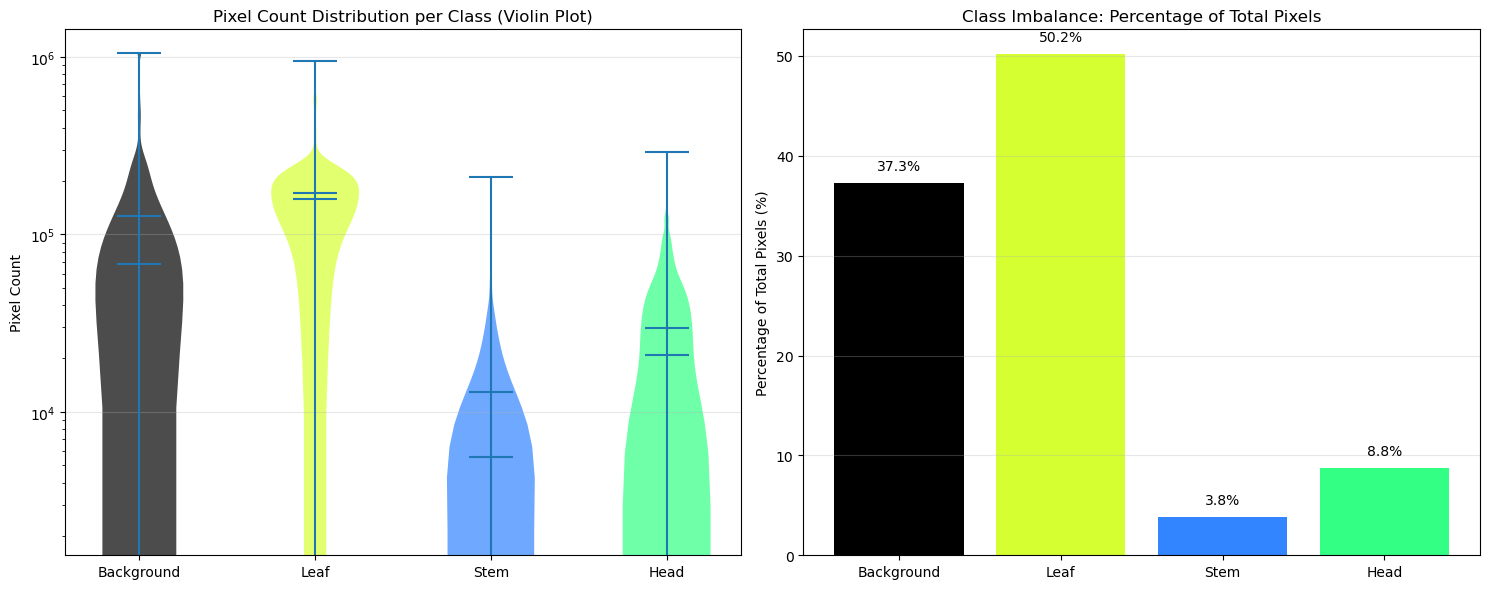

In [8]:
# Calculate summary statistics for each class
class_names = ['Background', 'Leaf', 'Stem', 'Head']
summary_stats = []

for class_id, class_name in enumerate(class_names):
    counts = class_counts[class_id]
    summary_stats.append({
        'Class': class_name,
        'Mean': np.mean(counts),
        'Median': np.median(counts),
        'Std': np.std(counts),
        'Min': np.min(counts),
        'Max': np.max(counts),
        'Total': np.sum(counts)
    })

# RGB colors from segmentation masks (normalised to 0-1 for matplotlib)
mask_colors = [
    (0, 0, 0),                    # Background: RGB(0, 0, 0) - black
    (214/255, 255/255, 50/255),   # Leaf: RGB(214, 255, 50) - yellow-green
    (50/255, 132/255, 255/255),   # Stem: RGB(50, 132, 255) - blue
    (50/255, 255/255, 132/255),   # Head: RGB(50, 255, 132) - cyan-green
]

# Create visualisation with violin plot and percentage chart
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

violin_parts = axes[0].violinplot([class_counts[i] for i in range(4)], 
                                   positions=range(4),
                                   showmeans=True, showmedians=True)

for pc, color in zip(violin_parts['bodies'], mask_colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

axes[0].set_xticks(range(4))
axes[0].set_xticklabels(class_names)
axes[0].set_ylabel('Pixel Count')
axes[0].set_title('Pixel Count Distribution per Class (Violin Plot)')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_yscale('log')

# Percentage of total pixels per class
total_pixels_per_class = [np.sum(class_counts[i]) for i in range(4)]
total_all = sum(total_pixels_per_class)
percentages = [100 * total / total_all for total in total_pixels_per_class]

axes[1].bar(class_names, percentages, color=mask_colors)
axes[1].set_ylabel('Percentage of Total Pixels (%)')
axes[1].set_title('Class Imbalance: Percentage of Total Pixels')
axes[1].grid(True, alpha=0.3, axis='y')

for i, (name, pct) in enumerate(zip(class_names, percentages)):
    axes[1].text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [9]:
# Count images with zero stems
stem_counts = np.array(class_counts[2])
head_counts = np.array(class_counts[3])
zero_stem_count = np.sum(stem_counts == 0)
zero_head_count = np.sum(head_counts == 0)

print(f"Images with zero stems: {zero_stem_count} out of {len(stem_counts)} ({100 * zero_stem_count / len(stem_counts):.1f}%)")
print(f"Images with zero heads: {zero_head_count} out of {len(head_counts)} ({100 * zero_head_count / len(head_counts):.1f}%)")

Images with zero stems: 249 out of 1096 (22.7%)
Images with zero heads: 357 out of 1096 (32.6%)


The dataset exhibits a severe class imbalance across the four segmentation classes. This is particularly problematic for stems and heads, which together make up less than 13% of the dataset.

To account for this imbalance, splits will be stratified based on dominant class to prevent underrepresentation of minority classes. During training, class weighting will be applied to the loss function to aid with segmentation.